## Customer Churn in Telecom Industry

In [72]:
import numpy as np
import pandas as pd


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA#, FastICA
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, learning_curve
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

SEED = 1987 # specify seed for reproducable results
pd.set_option('display.max_columns', None)


In [2]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [6]:
df.shape

(3333, 21)

In [7]:
df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [3]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [8]:
df.dtypes

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

In [14]:
num_cols = []
char_cols = []
bool_cols = []
for col in df.columns:
    if (df[col].dtype == 'int64') | (df[col].dtype == 'float64'):
        num_cols.append(col)

    elif (df[col].dtype == 'object'):
        char_cols.append(col)
    elif (df[col].dtype == 'bool'):
        bool_cols.append(col)
    else:
        pass

print('Num Cols:')
print(num_cols)
print('\n')
print('Char Cols:')
print(char_cols)
print('\n')
print('Bool Cols:')
print(bool_cols)

Num Cols:
['account length', 'area code', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']


Char Cols:
['state', 'phone number', 'international plan', 'voice mail plan']


Bool Cols:
['churn']


In [5]:
## Phone number is not numeric. Since we have '-' in between

In [18]:
df['state'].nunique()

51

In [10]:
df['international plan'].unique()

array(['no', 'yes'], dtype=object)

In [11]:
df['voice mail plan'].unique()

array(['yes', 'no'], dtype=object)

In [12]:
df['churn'].unique()

array([False,  True])

In [15]:
df['phone number'].nunique()

3333

In [17]:
df.shape

(3333, 21)

In [ ]:
## For all the customers we have seperate Phone Number. So lets drop phone number 

In [36]:
def preprocess_data(df):
    ## copy the data
    pre_df = df.copy()
    pre_df.columns = [ s.replace(' ','_') for s in pre_df.columns]
    pre_df.drop(['phone_number'], axis = 1 , inplace = True)
    pre_df['international_plan'] = pre_df['international_plan'].apply(lambda x: 0 if x=='no' else 1)
    pre_df['voice_mail_plan']    = pre_df['voice_mail_plan'].map({'yes':1, 'no':0})
    ## Using label encoder for State for now
    le =LabelEncoder()
    le.fit(pre_df['state'])
    pre_df['state'] = le.transform(pre_df['state'])
    pre_df['churn'] = pre_df['churn'].apply(lambda x : 1 if x else 0)
    return pre_df, le

##Call the preprocess_data function

pre_df , le = preprocess_data(df)

In [37]:
pre_df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [38]:
pre_df.describe()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,26.059406,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,14.824911,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,0.000000,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,26.000000,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,39.000000,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,50.000000,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


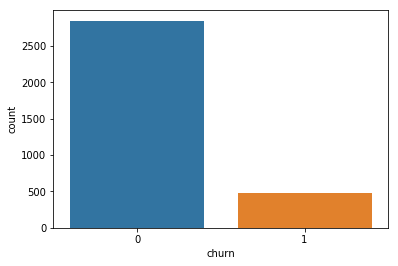

In [39]:
sns.countplot(pre_df['churn'])

In [56]:
## churn_pct

churn_pct = pre_df['churn'].sum()*100/pre_df['churn'].shape[0]

##print("Churn percentage is %.3f%%." %churn_pct)

print('Percentage of customers churned {:.2f} %'.format(churn_pct))

Percentage of customers churned 14.49 %


##### We do have class imbalance here 

In [68]:
pre_df.groupby(["state", "churn"]).size().unstack()

churn,0,1
state,,
0,49,3
1,72,8
2,44,11
3,60,4
4,25,9
5,57,9
6,62,12
7,49,5
8,52,9


In [77]:
pre_df.groupby(["state", "churn"]).size().unstack().columns

Int64Index([0, 1], dtype='int64', name='churn')

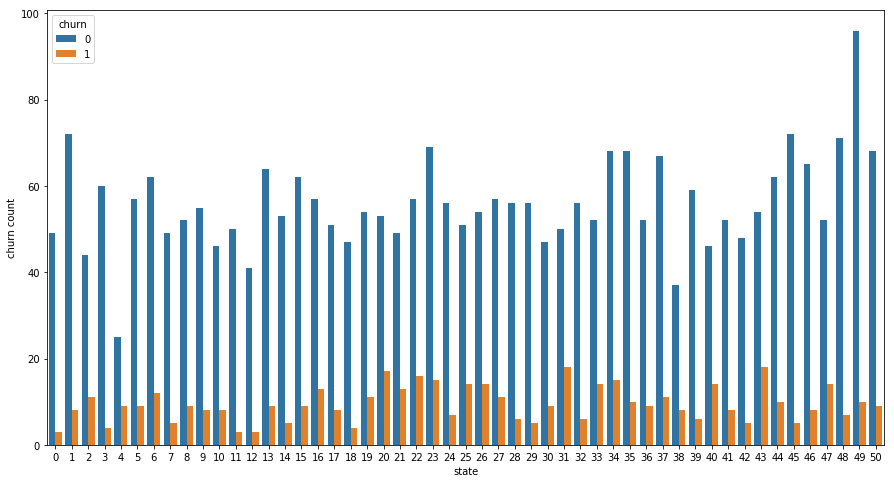

In [89]:
plt.figure(1, figsize=(15,8))
sns.countplot(x='state',data= pre_df, hue= 'churn')
plt.ylabel('churn count');

In [90]:
## We can see here the churn count is less for all the states.

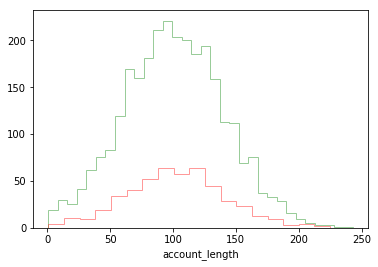

In [119]:
sns.distplot(pre_df[pre_df['churn']==0]['account_length'], color='g',hist_kws={"histtype": "step"}, kde= False);
sns.distplot(pre_df[pre_df['churn']==1]['account_length'], color='r',hist_kws={"histtype": "step"}, kde= False);

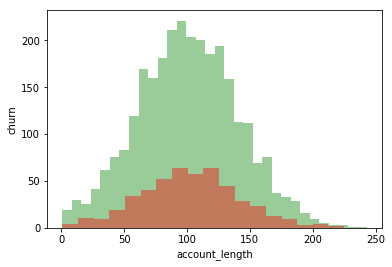

In [118]:
sns.distplot(pre_df[pre_df['churn']==0]['account_length'], color='g', kde= False)
#sns.distplot(pre_df[pre_df['churn']==1]['account_length'], color='r',hist_kws={"histtype": "step"}, kde= False);
sns.distplot(pre_df[pre_df['churn']==1]['account_length'], color='r', kde= False);
plt.ylabel('churn');

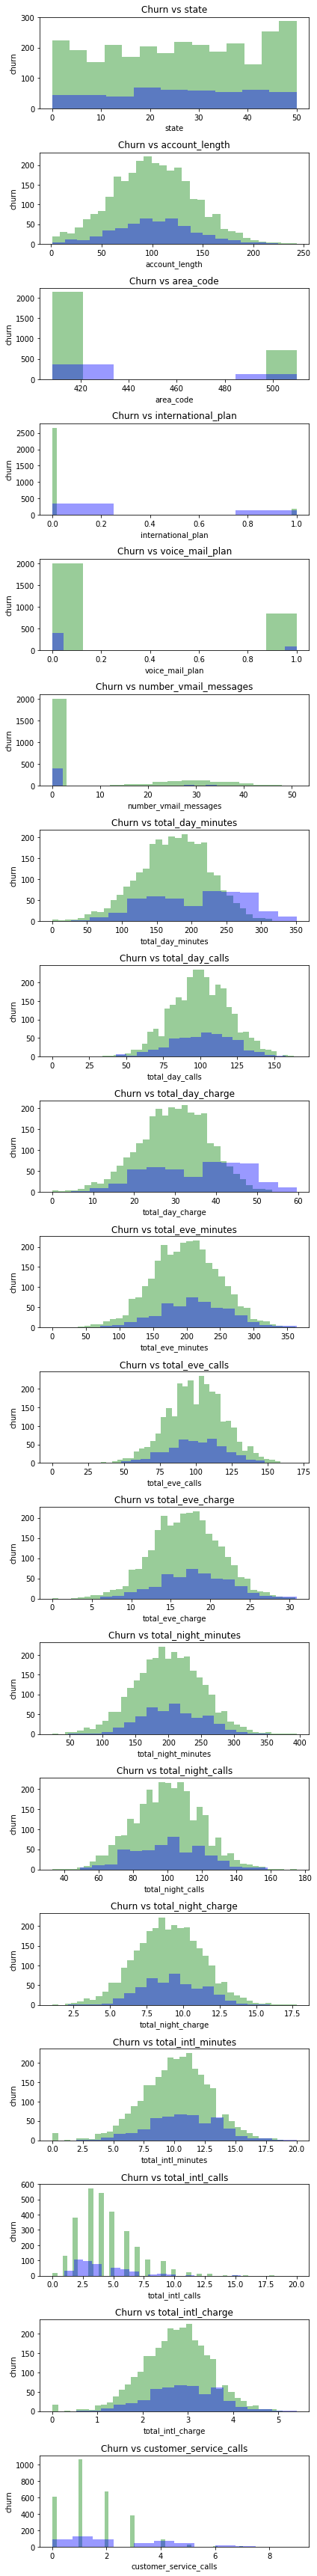

In [143]:
plt.figure(1, figsize= (6,50))
i=0
for col in pre_df.columns:
    if col == 'churn':
        continue
    i += 1
    plt.subplot(len(pre_df.columns),1,i)
    sns.distplot(pre_df[pre_df['churn']==0][col], color='g', kde= False)
    #sns.distplot(pre_df[pre_df['churn']==1]['account_length'], color='r',hist_kws={"histtype": "step"}, kde= False);
    sns.distplot(pre_df[pre_df['churn']==1][col], color='b', kde= False);
    plt.xlabel(col)
    plt.ylabel('churn')
    plt.title('Churn vs {}'.format(col))
    plt.tight_layout();

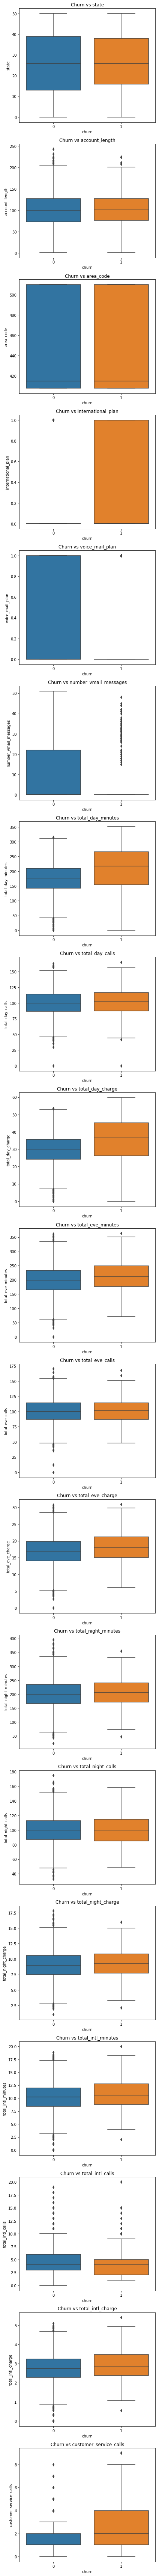

In [156]:
plt.figure(1, figsize= (6,100))
i=0
for col in pre_df.columns:
    if col == 'churn':
        continue
    i += 1
    plt.subplot(len(pre_df.columns),1,i)
    sns.boxplot(y =col,x = 'churn' , data=pre_df)
    plt.ylabel(col)
    plt.xlabel('churn')
    plt.title('Churn vs {}'.format(col))
    plt.tight_layout();

In [131]:
#pre_df[pre_df['churn']==1]['account_length'].plot.hist()

When we look at the box plot for the number of voice mail messages ("number_vmail_messages"), we can see that we have some outliers for the customers with churn, but most of them have send zero voice mail messages. The customers which did not churn instead tend to do more voice mail messages.
Similar to our findings in the histograms, we can see also in the box plot that the median of the total day minutes and the total day charge for churn clients is higher than the one of no-churn clients.
Looking at the total international calls ("total_intl_calls"), the box plot shows that both churn and no-churn customers are doing a similar amount of international calls, but the churn-customers tend to do longer calls as the median of churn customers for the total international minutes is higher than for the no-churn customers.

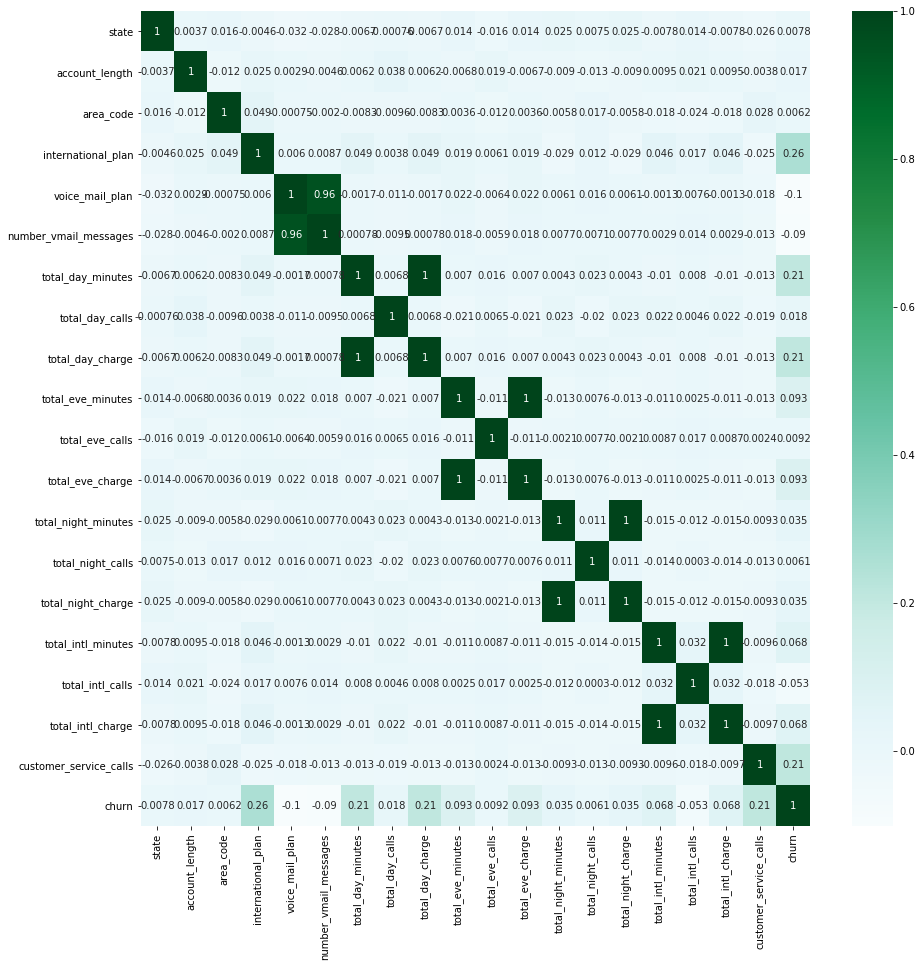

In [139]:
corr = pre_df.corr()
plt.figure(1, figsize = (15,15))

sns.heatmap(corr, annot = True,cmap= 'BuGn');

In [157]:
# save the duplicate features for later usage
duplicate_features = ["total_day_charge", "total_eve_charge", "total_night_charge", "total_intl_charge"]

In [161]:
df_y = pre_df['churn']

df_X = pre_df.drop(['churn'], axis =1)

In [163]:
# normalize the dataset (note: for decision tree/random forest it would not be needed)

df_X_normed = (df_X - df_X.mean())/df_X.std()

In [164]:
# calculate the principal components
pca = PCA(random_state=SEED)
df_X_pca = pca.fit_transform(df_X_normed)

In [ ]:
tot = sum(pca.explained_variance_) # total explained variance of all principal components
var_exp = [(i / tot) * 100 for i in sorted(pca.explained_variance_, reverse=True)] # individual explained variance
cum_var_exp = np.cumsum(var_exp) # cumulative explained variance

In [165]:
tot = sum(pca.explained_variance_) # total explained variance of all principal components
var_exp = [(i / tot) * 100 for i in sorted(pca.explained_variance_, reverse=True)] # individual explained variance
cum_var_exp = np.cumsum(var_exp) # cumulative explained variance

In [187]:
#plt.scatter(x = np.arange(1,len(cum_var_exp)+1), y= var_exp)

##### Explained Varience for PCA Components

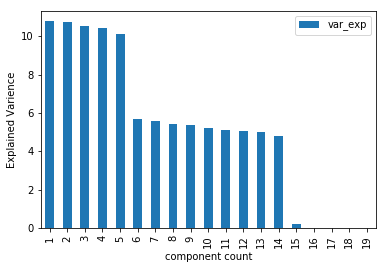

In [192]:
comp_varience = pd.DataFrame()

comp_varience['var_exp'] = var_exp
comp_varience['cum var_exp'] = cum_var_exp
comp_varience['component count'] = np.arange(1, len(var_exp)+1)

comp_varience.plot.bar(x= 'component count', y = 'var_exp');
plt.xlabel('component count')
plt.ylabel('Explained Varience');

##### Cumulative Explained Varience for PCA Components

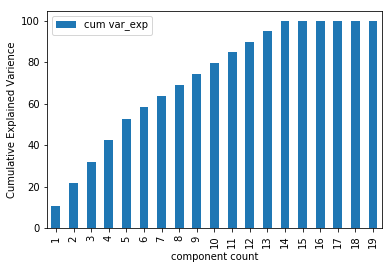

In [193]:
comp_varience.plot.bar(x= 'component count', y = 'cum var_exp');
plt.xlabel('component count')
plt.ylabel('Cumulative Explained Varience');

In [208]:
RANDOM_FOREST_PARAMS = {
    'clf__max_depth': [25, 50, 75],
    'clf__max_features': ["sqrt"], # just sqrt is used because values of log2 and sqrt are very similar for our number of features (10-19) 
    'clf__criterion': ['gini', 'entropy'],
    'clf__n_estimators': [100, 300, 500, 1000]
}

DECISION_TREE_PARAMS = {
    'clf__max_depth': [25, 50, 75],
    'clf__max_features': ["sqrt"], # just sqrt is used because values of log2 and sqrt are very similar for our number of features (10-19)
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_samples_split': [6, 10, 14],
}

LOGISTIC_REGRESSION_PARAMS = {
    'clf__solver': ['liblinear'],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2', 'l1']
}

KNN_PARAMS = {
    'clf__n_neighbors': [5, 15, 25, 35, 45, 55, 65],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2, 10]
}

KNN_PARAMS_UNIFORM = {
    'clf__n_neighbors': [5, 15, 25, 35, 45, 55, 65],
    'clf__weights': ['uniform'],
    'clf__p': [1, 2, 10]
}

SVM_PARAMS = [
{
    'clf__kernel': ['linear'],
    'clf__C': [0.1, 1, 10],
}, 
{
    'clf__kernel': ['rbf'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__gamma': [0.01, 0.1, 1, 10, 100],
}]

In [227]:
# prints the best grid search scores along with their parameters.

def print_best_grid_search_scores_with_params(grid_search):
    if not hasattr(grid_search, 'best_score_'):
        print('Classifier is not yet fit')
    else:
        print('Best grid scores on validation set:', grid_search.best_score_)
        print('Best Parameters:', grid_search.best_params_)

In [204]:
def do_gridsearch_with_cv(clf, params, X_train, y_train, cv, smote= None):
    '''
    GridSearch for a specific classifer 
    '''
    if smote is None:
        pipeline = Pipeline([('clf', clf)])
    else:
        pipeline = Pipeline([('sm', sm),('clf', clf)])
        
    gs = GridSearchCV(pipeline, params, cv=kf,n_jobs = -1, scoring = 'f1')
    gs.fit(X_train, y_train)
    return gs

In [210]:
def score_on_test_set(clfs, datasets):
    scores = []
    for c, (X_test, y_test) in zip(clfs, datasets):
        scores.append(c.score(X_test, y_test))
    return scores

In [198]:
n_components = 10
df_X_reduced = np.dot(df_X_normed.values, pca.components_[:n_components,:].T)
df_X_reduced = pd.DataFrame(df_X_reduced, columns=["PC#%d" % (x + 1) for x in range(n_components)])


In [202]:
X_train, X_test, y_train, y_test = train_test_split(df_X_normed, df_y, test_size=0.2, random_state=1987)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_X_reduced, df_y, test_size=0.2, random_state=1987)

cols_without_duplicate = [x for x in df_X_normed.columns if x not in duplicate_features]

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(df_X_normed[cols_without_duplicate], df_y, 
                                                                    test_size=0.2, random_state=1987)

In [203]:
print("Shape of the full train dataset:", X_train.shape)
print("Shape of the train dataset with reduced features", X_train_red.shape)
print("Shape of the transformed train dataset using the first 10 Principal Components", X_train_pca.shape)

Shape of the full train dataset: (2666, 19)
Shape of the train dataset with reduced features (2666, 15)
Shape of the transformed train dataset using the first 10 Principal Components (2666, 10)


In [205]:
SEED= 1987

sm = SMOTE(random_state=SEED)
kf = StratifiedKFold(n_splits=5, random_state=SEED)
clf_rf = RandomForestClassifier(random_state=SEED)
clf_balanced = RandomForestClassifier(random_state=SEED, class_weight="balanced")

In [211]:
%%time
gs_full = do_gridsearch_with_cv(clf_rf, RANDOM_FOREST_PARAMS, X_train, y_train, kf, smote=None)
gs_red = do_gridsearch_with_cv(clf_rf, RANDOM_FOREST_PARAMS, X_train_red, y_train_red, kf, smote=None)
gs_pca = do_gridsearch_with_cv(clf_rf, RANDOM_FOREST_PARAMS, X_train_pca, y_train_pca, kf, smote=None)
gss_raw = [gs_full, gs_red, gs_pca]

Wall time: 7min 19s


##### Without additional balancing techniques

In [215]:
test_results_raw = score_on_test_set(gss_raw, [(X_test, y_test), (X_test_red, y_test_red), (X_test_pca, y_test_pca)])
test_results_raw 

[0.7883211678832117, 0.7407407407407408, 0.47368421052631576]

##### Using class weights in the loss function

In [216]:
%%time
gs_full_balanced = do_gridsearch_with_cv(clf_balanced, RANDOM_FOREST_PARAMS, X_train, y_train, kf, smote=None)
gs_red_balanced = do_gridsearch_with_cv(clf_balanced, RANDOM_FOREST_PARAMS, X_train_red, y_train_red, kf, smote=None)
gs_pca_balanced = do_gridsearch_with_cv(clf_balanced, RANDOM_FOREST_PARAMS, X_train_pca, y_train_pca, kf, smote=None)
gss_balanced_weights = [gs_full_balanced, gs_red_balanced, gs_pca_balanced]

Wall time: 6min 23s


In [217]:
test_results_balanced_weights = score_on_test_set(gss_balanced_weights,
                                                  [(X_test, y_test), 
                                                   (X_test_red, y_test_red), (X_test_pca, y_test_pca)])

test_results_balanced_weights

[0.7445255474452553, 0.676923076923077, 0.5045045045045046]

##### Using Synthetic Minority Over-sampling Technique

In [218]:
%%time
gs_full_smote = do_gridsearch_with_cv(clf_rf, RANDOM_FOREST_PARAMS, X_train, y_train, kf, smote=sm)
gs_red_smote = do_gridsearch_with_cv(clf_rf, RANDOM_FOREST_PARAMS, X_train_red, y_train_red, kf, smote=sm)
gs_pca_smote = do_gridsearch_with_cv(clf_rf, RANDOM_FOREST_PARAMS, X_train_pca, y_train_pca, kf, smote=sm)
gss_smote = [gs_full_smote, gs_red_smote, gs_pca_smote]

Wall time: 11min 9s


In [219]:
test_results_smote = score_on_test_set(gss_smote, [(X_test, y_test), 
                                                   (X_test_red, y_test_red), (X_test_pca, y_test_pca)])

test_results_smote

[0.8079470198675496, 0.7612903225806452, 0.6037735849056604]

##### Comparison

In [220]:
dataset_strings = ["full dataset", "data set with reduced features", "dataset with first 10 principal components"]
method_strings = ["without any balancing", "using balanced class weights", "using SMOTE"]

result_strings = dict()
for ms, results in zip(method_strings, [test_results_raw, test_results_balanced_weights, test_results_smote]):
    for ds, res in zip(dataset_strings, results):
        string = "%.3f" % res + "     " + ds + " " + ms
        result_strings[string] = res
        2
result_strings = sorted(result_strings.items(), key=lambda kv: kv[1], reverse=True)
print("F1 score  dataset and method")
for k, _ in result_strings:
    print(k)

F1 score  dataset and method
0.808     full dataset using SMOTE
0.788     full dataset without any balancing
0.761     data set with reduced features using SMOTE
0.745     full dataset using balanced class weights
0.741     data set with reduced features without any balancing
0.677     data set with reduced features using balanced class weights
0.604     dataset with first 10 principal components using SMOTE
0.505     dataset with first 10 principal components using balanced class weights
0.474     dataset with first 10 principal components without any balancing


In [221]:
%%time
clf_lr = LogisticRegression(random_state=SEED)
gs_lr = do_gridsearch_with_cv(clf_lr, LOGISTIC_REGRESSION_PARAMS, X_train, y_train, kf, smote=sm)

Wall time: 7.71 s


In [228]:
print_best_grid_search_scores_with_params(gs_lr)

Best grid scores on validation set: 0.4773396418111947
Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}


In [233]:
gs_lr_score = gs_lr.score(X_test, y_test)

y_pred_lr = gs_lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=[0,1])

In [234]:
cm_df = pd.DataFrame(cm_lr.round(3), index=["true no churn", "true churn"], 
                     columns=["predicted no churn", "predicted churn"])
cm_df

,predicted no churn,predicted churn
true no churn,465,120
true churn,16,66


In [235]:
%%time
clf_knn = KNeighborsClassifier()
gs_knn = do_gridsearch_with_cv(clf_knn, KNN_PARAMS, X_train, y_train, kf, smote=sm)

Wall time: 3min 9s


In [236]:
print_best_grid_search_scores_with_params(gs_knn)

Best grid scores on validation set: 0.6191356742606174
Best Parameters: {'clf__n_neighbors': 65, 'clf__p': 1, 'clf__weights': 'distance'}


In [237]:
gs_knn_score = gs_knn.score(X_test, y_test)

y_pred_knn = gs_knn.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[0,1])

cm_df = pd.DataFrame(cm_knn.round(3), index=["true no churn", "true churn"], 
                     columns=["predicted no churn", "predicted churn"])
cm_df


,predicted no churn,predicted churn
true no churn,504,81
true churn,18,64


In [238]:
%%time
clf_svm = svm.SVC(random_state=SEED, probability=True)
gs_svm = do_gridsearch_with_cv(clf_svm, SVM_PARAMS, X_train, y_train, kf, smote=sm)

Wall time: 4min 14s


In [239]:
print_best_grid_search_scores_with_params(gs_svm)

Best grid scores on validation set: 0.6671648342687321
Best Parameters: {'clf__C': 100, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


In [240]:
gs_svm_score = gs_svm.score(X_test, y_test)
y_pred_svm = gs_svm.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)

pd.DataFrame(cm_svm.round(3), index=["true no churn", "true churn"], columns=["predicted no churn", "predicted churn"])

,predicted no churn,predicted churn
true no churn,554,31
true churn,29,53


In [241]:
%%time
clf_dt = DecisionTreeClassifier(random_state=SEED)
gs_dt = do_gridsearch_with_cv(clf_dt, DECISION_TREE_PARAMS, X_train, y_train, kf, smote=sm)

Wall time: 1.73 s


In [242]:
print_best_grid_search_scores_with_params(gs_dt)

Best grid scores on validation set: 0.6385080904353693
Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 25, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 14}


In [243]:
gs_dt_score = gs_dt.score(X_test, y_test)
y_pred_dt = gs_dt.predict(X_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)

cm_df = pd.DataFrame(cm_dt.round(3), index=["true no churn", "true churn"], columns=["predicted no churn", "predicted churn"])
cm_df

,predicted no churn,predicted churn
true no churn,524,61
true churn,31,51


In [244]:
%%time
clf_rf = RandomForestClassifier(random_state=SEED)
gs_rf = do_gridsearch_with_cv(clf_rf, RANDOM_FOREST_PARAMS, X_train, y_train, kf, smote=sm)

Wall time: 2min 36s


In [245]:
gs_rf_score = gs_rf.score(X_test, y_test)
y_pred_rf = gs_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

cm_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis] # normalize the confusion matrix

cm_df = pd.DataFrame(cm_rf.round(3), index=["true no churn", "true churn"], columns=["predicted no churn", "predicted churn"])
cm_df

,predicted no churn,predicted churn
true no churn,0.986,0.014
true churn,0.256,0.744


In [246]:
gs_rf_score = gs_rf.score(X_test, y_test)
y_pred_rf = gs_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

cm_df = pd.DataFrame(cm_rf.round(3), index=["true no churn", "true churn"], columns=["predicted no churn", "predicted churn"])
cm_df

,predicted no churn,predicted churn
true no churn,577,8
true churn,21,61


We may try implementing other algorithms 

In [ ]:
#ExtraTreesClassifier

#clf = ExtraTreesClassifier()


In [ ]:
#GradientBoostingClassifier

#clf = GradientBoostingClassifier()

In [ ]:
#AdaBoostClassifier

#clf = AdaBoostClassifier()

In [ ]:
#MultinomialNB

#clf = MultinomialNB()

In [ ]:
#XGBClassifier

#clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
#                        subsample=0.8, nthread=10, learning_rate=0.1)

In [ ]:
#print("accuracy_score",accuracy_score(yvalid, predictions))
#print("auc",roc_auc_score(yvalid, predictions))